# Ingesting UKDRI CRT Data with the DCARTE

## Derived datasets

We've already gone through how to use DCARTE to get UKDRI CRT raw datasets. However, a central element in the process of knowledge discovery (aka data science) is the creation of features that fuse different data sources, transform a single data source using some logic, or aggregate datasets to a relevant frequency.

Let's create a step by step example that will make this point simpler to follow. 

We start by importing dcarte and loading PIR Activity across the houses 

In [4]:
import dcarte 
import pandas as pd 
import seaborn as sns 
activity = dcarte.load('Activity','raw',since='2022-02-01',until='2022-02-20',reload=True)
activity.start_date.agg(['min','max','count'])

Processing activity :**

Finished Loading Activity in:                 82.9 seconds   


min      2022-02-01 00:00:01
max      2022-02-19 23:59:49
count                 453932
Name: start_date, dtype: object

We then inspect the DataFrame's info()

In [5]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453932 entries, 0 to 453931
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   start_date     453932 non-null  datetime64[ns]
 1   patient_id     453932 non-null  category      
 2   home_id        453932 non-null  category      
 3   location_id    453932 non-null  category      
 4   location_name  453932 non-null  category      
 5   source         453932 non-null  object        
dtypes: category(4), datetime64[ns](1), object(1)
memory usage: 9.1+ MB


In this example, we wish to convert the raw activity data into a wide one-hot encoding tabular format that allows us to easily analyse the level of activity among households over time (e.g. every six hours every day or every week). One of the first things we should look at is the frequency of activity throughout the various locations in order to simplify the data by deleting or merging certain areas around the household. The best technique to find such targets is to use the pandas plotting capabilities.

In [9]:
activity.patient_id.cat.categories

Index(['2GN1PHeHwRzNYQ7q4Nvg7g', '2zbyXzYNKPwiPtjaA2L64o',
       '3hY7Mp7u9YPo1xMARSxLhc', '4h1dAuzg9rdrhyojwxUS26',
       '64RLyRh1fEUutdhMnvu17d', '6xrbQMkh12eYMdP7Xi1ggc',
       '82jgn4MkSPaYsQZX92n9kC', '8MzeY8ZePeGa6kFKJpXoMm',
       '965K58vYarXQTZEgss6HzT', '9HYuS1aHmCBXidcwGhZBTm',
       '9YauALfsfPs11tkX1Rb9jq', 'AFqqwemwCJ5ECzaXBcQFHh',
       'AupBYL7RJpU4KLUmsWZ7Uz', 'B3cr4Euax91r63NSvVhrxs',
       'BjAJmKMnmScXNFfSGd5RWr', 'BqG6BCSqzJzxsiKHuMcrqr',
       'CC9UHg3L6QGurrhbqv1v36', 'DArgytxDspe3jPUMMLhnvk',
       'Dr1tnvKDk2bHG8YS21nwiR', 'EH76RUxUE8DUtjuw6qdqy1',
       'Ea5ofFVKwHmHWrZSQEd7uj', 'EzjmQuxceJzLATdtyUbDn8',
       'GN6rJBMTm987Q99Zd6umgT', 'HCahseCCzPyFVkut5ya5Dm',
       'HdozjhTxFXBhYAnKje524Q', 'Hpbmfij5E6hh19u1uKFXQT',
       'JCkDxjf4VxPZ9ApvwBXXhs', 'JEvSjBYo6KvDKHCGUnDNxm',
       'JHvi2gBhcufYzhmg4F1H9T', 'JQwQLzfRYX5KmetFSg69kK',
       'Jyn62ywXtasNk9E732LsER', 'K6HnqfpnKjDE2pRfKxE6sX',
       'KtDu28PYqvkTddiXFcETFZ', 'MghE4vUbHVo6WfjSiy2FkF

<AxesSubplot:>

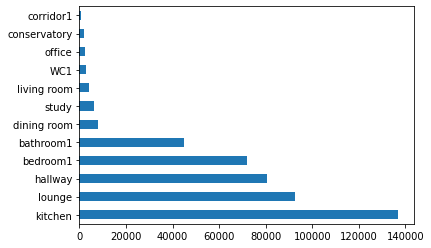

In [10]:
activity.location_name.value_counts().plot.barh()

The first step is to eliminate unique locations only in a few houses and combine contextually similar locations. This will make it easier to generalise our findings across all homes.

In [11]:
location_by_pid =  pd.crosstab(activity.location_name,activity.patient_id)
location_by_pid

patient_id,2GN1PHeHwRzNYQ7q4Nvg7g,2zbyXzYNKPwiPtjaA2L64o,3hY7Mp7u9YPo1xMARSxLhc,4h1dAuzg9rdrhyojwxUS26,64RLyRh1fEUutdhMnvu17d,6xrbQMkh12eYMdP7Xi1ggc,82jgn4MkSPaYsQZX92n9kC,8MzeY8ZePeGa6kFKJpXoMm,965K58vYarXQTZEgss6HzT,9HYuS1aHmCBXidcwGhZBTm,...,TwiUT1L1KSVnRdBuEywxfh,U2dZSjjycMm5bRNvHcLrAr,V4H3rTBaezHnbXufvjFQmM,VmrLbcBzyzacPx8WBnnttf,WSdj9TjJMT4oqpdMvMDsgg,WtYLx1dEr6hHgQDg8TKcGP,X7dJAZjrhEa1kRFUkoZVvg,XsfBVz6GP7XtvhY4CiAvuf,Xv41AaXiVYBKFAa7SLq8F5,YYGGmsEaf2gP4JNN9kMprV
location_name,,,,,,,,,,,,,,,,,,,,,
WC1,0,0,0,0,0,0,0,0,0,0,...,0,166,500,0,0,0,0,0,0,0
bathroom1,604,1039,768,851,975,1616,660,446,1140,58,...,483,448,439,532,669,516,782,0,407,2328
bedroom1,1418,1180,1003,345,1167,2724,801,1300,1015,485,...,2553,2247,1183,969,1566,1962,777,1151,1248,881
conservatory,0,0,0,0,0,0,0,0,0,0,...,0,0,1833,0,0,0,0,0,0,0
corridor1,0,0,0,0,0,0,0,0,741,0,...,0,0,0,0,0,0,0,0,0,0
dining room,0,0,2974,0,0,0,0,0,0,0,...,0,220,0,0,0,609,0,0,0,0
hallway,834,2190,0,844,1289,4517,1971,1838,1836,1241,...,1368,3083,1478,1701,1062,2517,3529,245,860,539
kitchen,1186,3359,2820,1754,2392,4020,1901,2291,3040,1811,...,1681,2468,3086,4783,3994,2977,2496,2850,1308,3033
living room,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2395,0


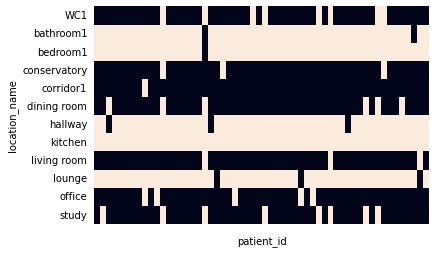

In [12]:
ax = sns.heatmap(location_by_pid>0,cbar=False)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels([]);

A simple interpretation of the above plot can be to do the following cleaning tasks: 
- filter the cellar and the conservatory, 
- merge WC1 and bathroom1 
- merge study and office
- merge the lounge, dining room and living room
- merge the corridor and hallway 

Let's see an example of how to do this using pandas 


In [13]:
mask = ~activity.location_name.isin(['cellar','conservatory'])
activity = activity[mask]
activity.location_name.unique()

['bedroom1', 'hallway', 'lounge', 'bathroom1', 'kitchen', ..., 'study', 'WC1', 'dining room', 'office', 'corridor1']
Length: 11
Categories (12, object): ['WC1', 'bathroom1', 'bedroom1', 'conservatory', ..., 'living room', 'lounge', 'office', 'study']

There are many ways to remap one value into another value in Python. However, in the process of transparency, interpretability and ease of change, I find the dictionary approach shown below to be the simplest to foolow and implement. 

In [14]:
mapping = {
    'bedroom1':'bedroom', 
    'bathroom1':'bathroom', 
    'hallway':'hallway', 
    'lounge':'lounge', 
    'kitchen':'kitchen',
    'living room':'lounge', 
    'corridor1':'hallway', 
    'dining room':'lounge', 
    'WC1':'bathroom', 
    'study':'study',
    'office':'study'}
activity.location_name = activity.location_name.map(mapping)
activity.location_name.unique()

array(['bedroom', 'hallway', 'lounge', 'bathroom', 'kitchen', 'study'],
      dtype=object)

Revisiting the plots we used before is a useful sanity check to validate that the changes we made we applied. 

<AxesSubplot:>

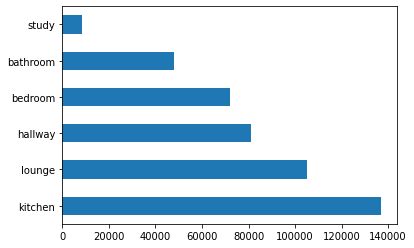

In [15]:
activity.location_name.value_counts().plot.barh()

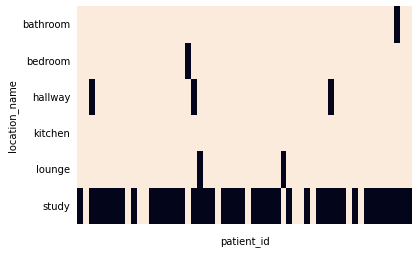

In [16]:
ax = sns.heatmap(pd.crosstab(activity.location_name,activity.patient_id)>0,cbar=False)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels([]);

After cleaning the location_name we can select just columns of intrest by passing a list of columns names to the DataFrame. 

In [17]:
activity[['start_date','patient_id','location_name']]

,start_date,patient_id,location_name
0,2022-02-01 00:00:01,BqG6BCSqzJzxsiKHuMcrqr,bedroom
1,2022-02-01 00:00:05,PtSJCv5bDWvZe3f1V7wRgQ,hallway
2,2022-02-01 00:00:06,PtSJCv5bDWvZe3f1V7wRgQ,lounge
3,2022-02-01 00:00:09,TDYFcFDBmhxGymqBtvKnqV,bedroom
4,2022-02-01 00:00:11,V4H3rTBaezHnbXufvjFQmM,lounge
...,...,...,...
453927,2022-02-19 23:59:06,8MzeY8ZePeGa6kFKJpXoMm,lounge
453928,2022-02-19 23:59:21,TwiUT1L1KSVnRdBuEywxfh,bedroom
453929,2022-02-19 23:59:24,8MzeY8ZePeGa6kFKJpXoMm,kitchen
453930,2022-02-19 23:59:38,9HYuS1aHmCBXidcwGhZBTm,bedroom


Now, let's say we decide to merge the study with the lounge location, all we need to run the entire process again and update the mapping dictionary.  

In [19]:
activity = dcarte.load('Activity','raw',since='2022-02-01',until='2022-02-20',reload=False)
mask = ~activity.location_name.isin(['cellar','conservatory'])
activity = activity[mask]
mapping = {
    'bedroom1':'bedroom', 
    'bathroom1':'bathroom', 
    'hallway':'hallway', 
    'lounge':'lounge', 
    'kitchen':'kitchen',
    'living room':'lounge', 
    'corridor1':'hallway', 
    'dining room':'lounge', 
    'WC1':'bathroom', 
    'study':'lounge',
    'office':'lounge'}
activity.location_name = activity.location_name.map(mapping)
activity.location_name.unique()

Finished Loading activity in:                  0.1 seconds   
Finished Loading Activity in:                  0.1 seconds   


array(['bedroom', 'hallway', 'lounge', 'bathroom', 'kitchen'],
      dtype=object)

In the end, we now have a single dataset in which the majority of households are similar and there are very few homes with missing locations.

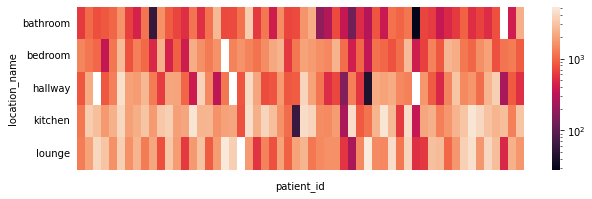

In [20]:
df = pd.crosstab(activity.location_name,activity.patient_id)
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,3))
sns.heatmap(df,  norm=LogNorm(),ax=ax)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels([]);

Converting this dataset to a wide one-hot encoding format where time and patient ids are the indexes and the different locations are the columns requires calling a pandas function called `pd.get_dummies`.

In [21]:
activity = activity.set_index(['patient_id','start_date']).location_name
activity = pd.get_dummies(activity)
activity

bathroom  bedroom  hallway  \
patient_id             start_date                                        
BqG6BCSqzJzxsiKHuMcrqr 2022-02-01 00:00:01         0        1        0   
PtSJCv5bDWvZe3f1V7wRgQ 2022-02-01 00:00:05         0        0        1   
                       2022-02-01 00:00:06         0        0        0   
TDYFcFDBmhxGymqBtvKnqV 2022-02-01 00:00:09         0        1        0   
V4H3rTBaezHnbXufvjFQmM 2022-02-01 00:00:11         0        0        0   
...                                              ...      ...      ...   
8MzeY8ZePeGa6kFKJpXoMm 2022-02-19 23:59:06         0        0        0   
TwiUT1L1KSVnRdBuEywxfh 2022-02-19 23:59:21         0        1        0   
8MzeY8ZePeGa6kFKJpXoMm 2022-02-19 23:59:24         0        0        0   
9HYuS1aHmCBXidcwGhZBTm 2022-02-19 23:59:38         0        1        0   
                       2022-02-19 23:59:49         0        0        1   

                                            kitchen  lounge  
patient_id             start_date                            
BqG6BCSqzJzxsiKHuMcrqr 2022-02-01 00:00:01        0       0  
PtSJCv5bDWvZe3f1V7wRgQ 2022-02-01 00:00:05        0       0  
                       2022-02-01 00:00:06        0       1  
TDYFcFDBmhxGymqBtvKnqV 2022-02-01 00:00:09        0       0  
V4H3rTBaezHnbXufvjFQmM 2022-02-01 00:00:11        0       1  
...                                             ...     ...  
8MzeY8ZePeGa6kFKJpXoMm 2022-02-19 23:59:06        0       1  
TwiUT1L1KSVnRdBuEywxfh 2022-02-19 23:59:21        0       0  
8MzeY8ZePeGa6kFKJpXoMm 2022-02-19 23:59:24        1       0  
9HYuS1aHmCBXidcwGhZBTm 2022-02-19 23:59:38        0       0  
                       2022-02-19 23:59:49        0       0  

[451829 rows x 5 columns]

It would be helpful to formalise this process so that it does not require us to run it each time. Formalising derived datasets is another aspect of dcarte that simplifies the collaborations on different parts of data processing. Dcarte comes armed with three samples derived datasets that can be available using a simple command. Running any of the three functions listed below will add a single domain to your dcarte library. These functions will automatically download needed datasets and create the different local datasets described internally.

In [14]:
from dcarte.derived import (create_base_datasets,
                            create_weekly_profile)
create_base_datasets()

Finished Loading door in:                      0.0 seconds   
Finished Loading doors in:                     0.0 seconds   
Finished Loading environmental in:             0.1 seconds   
Finished Loading device_types in:              0.0 seconds   
Finished Loading appliances in:                0.0 seconds   
Finished Loading doors in:                     0.0 seconds   
Finished Loading activity in:                  0.0 seconds   
Finished Loading device_types in:              0.0 seconds   
Finished Loading activity in:                  0.0 seconds   
Finished Loading entryway in:                  0.0 seconds   
Finished Loading sleep_event in:               0.1 seconds   
Finished Loading vital_signs in:               0.0 seconds   
Finished Loading blood_pressure in:            0.0 seconds   
Finished Loading device_types in:              0.0 seconds   
Finished Loading sleep_mat in:                 0.0 seconds   
Finished Loading motion in:                    0.0 seconds   


In [15]:
create_weekly_profile()

Finished Loading motion in:                    0.1 seconds   
Finished Loading activity_dailies in:          0.0 seconds   
Finished Loading sleep in:                     0.0 seconds   
Finished Loading sleep_dailies in:             0.0 seconds   
Finished Loading physiology in:                0.0 seconds   
Finished Loading physiology_dailies in:        0.0 seconds   
Finished Loading Habitat in:                   0.1 seconds   
Finished Loading Habitat in:                   0.1 seconds   


When you run dcarte.domains() for the final time, you will notice that you now have a greater number of domains under your control than before. In the following section, we will go over one of these recipes in detail and show you how to create an expansion of it on your own using the material you have gained so far in this tutorial.

In [ ]:
dcarte.domains()